#### &nbsp;
# **Twitter Sentiment Analysis Using Scikit-Learn**
#### Author: &nbsp; Ankit S Kumar
#### &nbsp;

## Project Description
In the era of digital communication, social media platforms like Twitter have become pivotal for individuals and organisations to express opinions, share news, and engage with communities. With millions of tweets generated daily, Twitter provides a rich source of data that can be analyzed to gauge public sentiment on various topics. Twitter sentiment analysis leverages Natural Language Processing (NLP) and machine learning techniques to identify and classify the sentiment behind tweets, categorizing them as positive, negative, or neutral.

In this project, we perform Twitter Sentiment Analysis employing classification models from Scikit-Learn library and categorise the general sentiment of tweets as either positive or negative. This project demonstrates different elements of text processing, feature extraction, and model training. Throughout the project, the Python programming language is utilised. 

## Objectives
- To preprocess and clean tweet text data.
- To convert textual data into numerical features using TF-IDF vectorisation.
- To train machine learning models to classify the sentiment of tweets.
- To evaluate and compare models' performance using appropriate metrics or KPIs.

## Project Workflow

### 1. Import libraries
Import necessary libraries for data handling, preprocessing, and model building.
- *Pandas*: For data manipulation and analysis.
- *NumPy*: For numerical computations.
- *NLTK* and *Re*: For text preprocessing and tokenization.
- *Scikit-Learn*: For machine learning algorithms and feature extraction.
- *Matplotlib*: For data visualisation

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk, re
from nltk.corpus import twitter_samples, stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.naive_bayes import MultinomialNB


### 2. Import the Twitter dataset
The Twitter dataset is loaded from the nltk repository. It consists of two lists (containing tweets as strings), each named with corresponding sentiments -- positive or negative. After importing the dataset, tweets are labelled as 1 for positive and 0 for negative. Finally, the dataset is converted into Pandas dataframe for efficient data processing.

In [42]:
# Loading twitter data (lists) from nltk
nltk.download('twitter_samples')
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')
tweets = positive_tweets + negative_tweets
label = np.zeros(len(tweets),dtype='int8')
label[:len(positive_tweets)] = 1

# Converting lists to Pandas Dataframes
tweets_df = pd.DataFrame([label, tweets], index=['label', 'tweet']).T
tweets_df['label'] = tweets_df['label'].astype('int8')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\Ankit\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


### 3. Exploratory data analysis

After collecting the Twitter dataset, the next crucial step is to perform Exploratory Data Analysis (EDA). EDA helps in understanding the dataset and gaining insights that may inform further preprocessing and modelling steps.

##### Checking the dataset structure:

In [43]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   10000 non-null  int8  
 1   tweet   10000 non-null  object
dtypes: int8(1), object(1)
memory usage: 88.0+ KB


In [44]:
tweets_df.head()

,label,tweet
0,1,#FollowFriday @France_Inte @PKuchly57 @Milipol...
1,1,@Lamb2ja Hey James! How odd :/ Please call our...
2,1,@DespiteOfficial we had a listen last night :)...
3,1,@97sides CONGRATS :)
4,1,yeaaaah yippppy!!! my accnt verified rqst has...


##### Missing Values and Duplicates:
The dataset is checked for missing values and duplicates. Addressing these issues ensures the data's integrity and quality.

In [45]:
#Checking for null cells
tweets_df.isnull().sum()

label    0
tweet    0
dtype: int64

In [46]:
#Checking for duplicate tweets
tweets_df['tweet'].duplicated().sum()

0

##### Tweet Length Statistics:
Descriptive statistics for tweet lengths are calculated separately for positive and negative tweets. This reveals if there's a significant difference in tweet lengths between the two sentiments. In some projects, this information could be used as an interesting feature for the model.

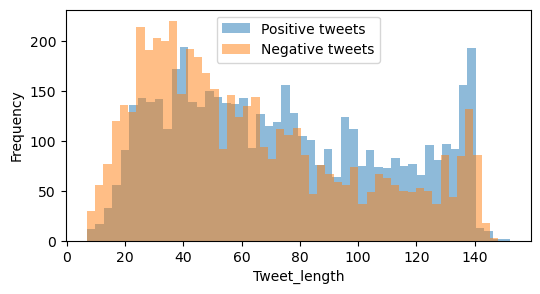

In [47]:
# Get the length of the tweets
tweets_df['tweet_length'] = tweets_df['tweet'].apply(len)

#Plotting the histogram of tweet lengths
pos_tweet_len = tweets_df[tweets_df['label']==1]['tweet_length']
neg_tweet_len = tweets_df[tweets_df['label']==0]['tweet_length']
plt.figure(figsize=(6, 3))
pos_tweet_len.plot(kind='hist', alpha=0.5, label='Positive tweets', bins=50)
neg_tweet_len.plot(kind='hist', alpha=0.5, label='Negative tweets', bins=50)
plt.xlabel('Tweet_length')
plt.ylabel('Frequency')
plt.legend()

In [48]:
tweet_stats = pd.concat([pos_tweet_len.describe(), neg_tweet_len.describe()], axis=1)
tweet_stats.columns = ['Positive tweets', 'Negative tweets']
tweet_stats

,Positive tweets,Negative tweets
count,5000.000000,5000.000000
mean,73.688200,63.387200
std,36.858539,36.704069
min,7.000000,7.000000
25%,42.000000,34.000000
50%,69.000000,54.000000
75%,103.000000,88.000000
max,152.000000,148.000000


**Verdict**: In the dataset, there are 5000 tweets, each for positive and negative sentiments. Positive tweets tend to be longer on average than negative tweets. The mean length of positive tweets is about 10 characters longer than that of negative tweets.

### 4. Data Preprocessing
Data preprocessing is an important step in the workflow of NLP projects like sentiment analysis. It involves transforming raw/unstructured text data into a clean and structured format that improves the accuracy and efficiency of machine learning models. In the current dataset, each tweet is preprocessed by employing a pipeline that performs the following functions:
- *Cleaning*: Convert text to lowercase and remove URLs, mentions, hashtags, punctuation, etc.
- *Tokenization*: Split the text into individual words (tokens) to perform stopword removal and stemming.
- *Stopword Removal*: Remove common words that do not contribute much to the sentiment (e.g., "the", "is", "and").
- *Stemming*: Convert words to their base forms that reduces the number of unique words in the dataset. (e.g., "connect," "connected," "connecting," and "connection" can all be reduced to "connect")

In [55]:
# Defining function to preprocess tweets

rx_tick = re.compile(r'\$\w*') # remove stock market tickers like $GE
rx_handle = re.compile(r'\@\w*') # remove handles like @user
rx_RT = re.compile(r'^RT[\s]+')# remove old style retweet text "RT"
rx_hyp = re.compile(r'https?://[^\s\n\r]+') # remove hyperlinks
rx_hash = re.compile(r'#') #removing the hash # sign from the hashtag
rx_alpha = re.compile(r'[^A-Za-z0-9 ]+') #only retain alphabets and numbers

nltk_tokenize = TweetTokenizer(reduce_len=True).tokenize #Tokenization
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) #Stopword removal
nltk_stem = SnowballStemmer(language='english').stem #Stemming

def tweet_preprocess_pipeline(tweet):

    tweet = tweet.lower()
    tweet = rx_tick.sub('',tweet)
    tweet = rx_handle.sub('',tweet)
    tweet = rx_RT.sub('',tweet)
    tweet = rx_hyp.sub('',tweet)
    tweet = rx_hash.sub('',tweet)
    tweet = rx_alpha.sub('',tweet)
    tokens = nltk_tokenize(tweet)
    tokens = [nltk_stem(w) for w in tokens if w not in stop_words and len(w)>1]
    tweet = ' '.join(tokens) 
    
    return tweet


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ankit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [58]:
#Preprocess tweets using a pipeline
tweets_df['cleaned_tweet'] = tweets_df['tweet'].apply(tweet_preprocess_pipeline)

#Removing rows with empty "cleaned_tweet" column
tweets_df = tweets_df[tweets_df['cleaned_tweet'].apply(lambda x: x.strip() != '')]
tweets_df.reset_index(drop=True, inplace=True)

tweets_df

,label,tweet,tweet_length,cleaned_tweet
0,1,#FollowFriday @France_Inte @PKuchly57 @Milipol...,111,followfriday top engag member communiti week
1,1,@Lamb2ja Hey James! How odd :/ Please call our...,126,hey jame odd pleas call contact centr 02392441...
2,1,@DespiteOfficial we had a listen last night :)...,107,listen last night bleed amaz track scotland
3,1,@97sides CONGRATS :),20,congrat
4,1,yeaaaah yippppy!!! my accnt verified rqst has...,106,yeaaah yipppi accnt verifi rqst succeed got bl...
...,...,...,...,...
9918,0,I wanna change my avi but uSanele :(,36,wanna chang avi usanel
9919,0,MY PUPPY BROKE HER FOOT :(,26,puppi broke foot
9920,0,where's all the jaebum baby pictures :((,40,where jaebum babi pictur
9921,0,But but Mr Ahmad Maslan cooks too :( https://t...,60,mr ahmad maslan cook


**Verdict**: The cleaned tweet is saved in the last column of the dataframe. The complexity of the tweet is significantly reduced following the preprocessing step. This ensures that the text data is in a suitable format for extracting meaningful features, ultimately leading to more accurate and reliable prediction of sentiments.

### 5. Feature extraction


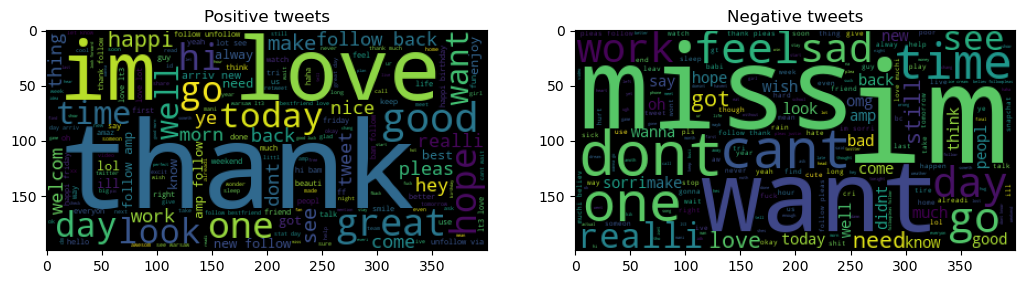

In [74]:
pos_tweet_cleaned = ' '.join(tweets_df[tweets_df['label']==1]['cleaned_tweet'])
neg_tweet_cleaned = ' '.join(tweets_df[tweets_df['label']==0]['cleaned_tweet'])

plt.figure(figsize=(12.5,3))
plt.subplot(121)
plt.imshow(WordCloud().generate(pos_tweet_cleaned))
plt.title('Positive tweets')
plt.subplot(122)
plt.title('Negative tweets')
plt.imshow(WordCloud().generate(neg_tweet_cleaned))

Each tweet serves as a document, and the entire collection of tweets forms the corpus.

In [94]:
X_train, X_test, y_train, y_test =  train_test_split(tweets_df['cleaned_tweet'], tweets_df['label'], test_size = 0.15)

In [95]:
#Count Vectorizer: Useful when word frequency is more important than their relative importance across the corpus. It can be a good starting point for simpler models and smaller datasets.
#TF-IDF Vectorizer: Often preferred for more sophisticated text analysis tasks where the importance of words relative to the entire corpus matters. It generally provides better performance for text classification, information retrieval, and similar tasks.


In [96]:
#Feature extraction using TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [97]:
X_train_tfidf.shape

(8434, 5000)

# TRAIN CLASSIFIER MODELS AND EVALUATE KPIs

In [98]:
# Evaluate the model
def eval_model(y_test, y_pred, ModelName):
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f'Model: {ModelName}')
    print(f'Accuracy: {accuracy}')
    print('Classification Report:')
    print(report)

In [101]:
model_NB = MultinomialNB()
model_NB.fit(X_train_tfidf, y_train)
y_pred = model_NB.predict(X_test_tfidf)
eval_model(y_test, y_pred, 'Naive Bayes')

Model: Naive Bayes
Accuracy: 0.758226997985225
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       762
           1       0.74      0.77      0.76       727

    accuracy                           0.76      1489
   macro avg       0.76      0.76      0.76      1489
weighted avg       0.76      0.76      0.76      1489



In [102]:
model_LR = LogisticRegression()
model_LR.fit(X_train_tfidf, y_train)
y_pred = model_LR.predict(X_test_tfidf)
eval_model(y_test, y_pred, 'Logistic Regression')

Model: Logistic Regression
Accuracy: 0.7743451981195433
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.79      0.78       762
           1       0.77      0.76      0.77       727

    accuracy                           0.77      1489
   macro avg       0.77      0.77      0.77      1489
weighted avg       0.77      0.77      0.77      1489



In [103]:
model_GB = GradientBoostingClassifier()
model_GB.fit(X_train_tfidf, y_train)
y_pred = model_GB.predict(X_test_tfidf)
eval_model(y_test, y_pred, 'Gradient Boosting')

Model: Gradient Boosting
Accuracy: 0.7078576225654802
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.91      0.76       762
           1       0.85      0.49      0.62       727

    accuracy                           0.71      1489
   macro avg       0.75      0.70      0.69      1489
weighted avg       0.75      0.71      0.69      1489

